In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Optional: xgboost (if available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Path to CSV (change if needed)
DATA_PATH = "C:/Users/Admin/github-classroom/Caty175/Caty-PolyWatch/ML model/Malware_Analysis.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH} - change DATA_PATH to your CSV location")

# ---------------- Load data ----------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (1308, 395)


In [4]:
# ---------------- Identify label ----------------
label_candidates = [c for c in df.columns if c.lower() in ("label","target","y","class")]
label_col = label_candidates[0] if label_candidates else df.columns[-1]
print("Using label column:", label_col)

Using label column: rule_with_sqlite


In [5]:
# ---------------- Detect dynamic / TF-IDF columns ----------------
# Text dynamic col heuristics
text_dynamic_cols = [c for c in df.columns if any(k in c.lower() for k in ("api","call","calls","sequence","trace")) and df[c].dtype == object]
dynamic_text_col = text_dynamic_cols[0] if text_dynamic_cols else None

# TF-IDF numeric columns heuristics
tfidf_cols = [c for c in df.columns if c.lower().startswith("tfidf") or c.lower().startswith("x_tfidf") or c.lower().startswith("tfidf_")]
if not tfidf_cols:
    # fallback: if many numeric columns exist, assume those (but we'll exclude static heuristics later)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols_no_label = [c for c in numeric_cols if c != label_col]
    if len(numeric_cols_no_label) > 50:
        tfidf_cols = numeric_cols_no_label

In [11]:
# ---------------- Labels ----------------
y = df[label_col].copy()

# Handle missing labels
if y.isna().any():
    print(f"[!] Found {y.isna().sum()} missing labels in '{label_col}'. Removing those rows...")
    df = df.dropna(subset=[label_col])
    y = df[label_col].copy()

# Encode labels if necessary
if y.dtype == object or y.dtype == bool:
    le = LabelEncoder()
    y = le.fit_transform(y)
    classes = le.classes_
else:
    classes = np.unique(y)

# Ensure numeric, no NaN, no inf
y = np.array(y, dtype=float)
y = np.nan_to_num(y, nan=0.0)
n_classes = len(np.unique(y))
print("Detected number of classes:", n_classes)


[!] Found 197 missing labels in 'rule_with_sqlite'. Removing those rows...
Detected number of classes: 2


In [12]:
# ---------------- Static features selection ----------------
exclude_cols = {label_col}
if dynamic_text_col:
    exclude_cols.add(dynamic_text_col)
exclude_cols.update(tfidf_cols)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Heuristic static keywords
static_keywords = ("entropy","dll","registry","file","size","count","import","hash","md5","sha","pe_")
static_features = [c for c in df.columns if any(k in c.lower() for k in static_keywords) and c in numeric_cols and c != label_col]
if not static_features:
    # if none found, use numeric columns excluding tfidf candidates
    static_features = [c for c in numeric_cols if c not in exclude_cols and c != label_col]

print(f"Using {len(static_features)} static features (examples):", static_features[:8])

# Prepare static feature matrix
X_static = df[static_features].copy()
imputer = SimpleImputer(strategy="median")
X_static_imputed = imputer.fit_transform(X_static)
scaler = StandardScaler()
X_static_scaled = scaler.fit_transform(X_static_imputed)

Using 103 static features (examples): ['API_NtOpenFile', 'API_NtCreateFile', 'API_LdrLoadDll', 'API_NtWriteFile', 'API_GetFileSize', 'API_NtDeviceIoControlFile', 'API_DeleteFileW', 'API_NtReadFile']


In [13]:
# ---------------- Dynamic features for LSTM ----------------
use_text_sequence_for_lstm = False
if dynamic_text_col:
    use_text_sequence_for_lstm = True
    texts = df[dynamic_text_col].fillna("").astype(str).tolist()
    texts = [t.replace(",", " ") for t in texts]
    MAX_NUM_WORDS = 20000
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    lengths = [len(s) for s in sequences]
    maxlen = int(np.percentile(lengths, 95)) if len(lengths)>0 else 100
    maxlen = max(20, maxlen)
    X_seq = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
    print("Prepared token sequences for LSTM:", X_seq.shape)
else:
    if not tfidf_cols:
        raise RuntimeError("No dynamic text column and no TF-IDF numeric columns detected. Provide one of them.")
    X_tfidf = df[tfidf_cols].fillna(0).astype(float).values
    # reshape to (n_samples, timesteps, features) => treat each tfidf dim as a timestep with feature=1
    X_seq = X_tfidf.reshape((X_tfidf.shape[0], X_tfidf.shape[1], 1))
    print("Prepared TF-IDF numeric data reshaped for LSTM:", X_seq.shape)

Prepared TF-IDF numeric data reshaped for LSTM: (1111, 383, 1)


In [14]:
# ---------------- Train/test split (consistent) ----------------
RANDOM_STATE = 42
Xs_train, Xs_test, y_train, y_test = train_test_split(X_static_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if n_classes>1 else None)
if use_text_sequence_for_lstm:
    Xd_train, Xd_test = train_test_split(X_seq, test_size=0.2, random_state=RANDOM_STATE, stratify=y if n_classes>1 else None)
else:
    Xd_train, Xd_test = train_test_split(X_seq, test_size=0.2, random_state=RANDOM_STATE, stratify=y if n_classes>1 else None)

print("Static shapes:", Xs_train.shape, Xs_test.shape)
print("Dynamic shapes:", Xd_train.shape, Xd_test.shape)

Static shapes: (888, 103) (223, 103)
Dynamic shapes: (888, 383, 1) (223, 383, 1)


In [16]:

# ---------------- RandomForest on static features ----------------
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
print("Training RandomForest...")
rf.fit(Xs_train, y_train)
rf_path = r"C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\rf_model.joblib"
joblib.dump({"model": rf, "imputer": imputer, "scaler": scaler, "static_features": static_features}, rf_path)
print("RandomForest saved to:", rf_path)

# RF probabilities
if n_classes == 2:
    rf_proba_test = rf.predict_proba(Xs_test)[:,1]
else:
    rf_proba_test = rf.predict_proba(Xs_test)

Training RandomForest...
RandomForest saved to: C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\rf_model.joblib


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,721 (276.25 KB)

 Trainable params: 70,721 (276.25 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM...
Epoch 1/25


14/14 - 6s - 414ms/step - accuracy: 0.9572 - loss: 0.4182 - val_accuracy: 0.9955 - val_loss: 0.0347
Epoch 2/25
14/14 - 3s - 245ms/step - accuracy: 0.9966 - loss: 0.0287 - val_accuracy: 0.9955 - val_loss: 0.0392
Epoch 3/25


14/14 - 3s - 232ms/step - accuracy: 0.9966 - loss: 0.0273 - val_accuracy: 0.9955 - val_loss: 0.0320
Epoch 4/25


14/14 - 3s - 232ms/step - accuracy: 0.9966 - loss: 0.0248 - val_accuracy: 0.9955 - val_loss: 0.0288
Epoch 5/25


14/14 - 3s - 240ms/step - accuracy: 0.9966 - loss: 0.0253 - val_accuracy: 0.9955 - val_loss: 0.0288
Epoch 6/25
14/14 - 4s - 275ms/step - accuracy: 0.9966 - loss: 0.0229 - val_accuracy: 0.9955 - val_loss: 0.0297
Epoch 7/25
14/14 - 5s - 347ms/step - accuracy: 0.9966 - loss: 0.0226 - val_accuracy: 0.9955 - val_loss: 0.0295
Epoch 8/25
14/14 - 5s - 339ms/step - accuracy: 0.9966 - loss: 0.0248 - val_accuracy: 0.9955 - val_loss: 0.0288
Epoch 9/25
14/14 - 4s - 301ms/step - accuracy: 0.9966 - loss: 0.0259 - val_accuracy: 0.9955 - val_loss: 0.0288
LSTM training done. Best checkpoint: C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\lstm_model_best.h5
Saved LSTM model to: C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\lstm_model.keras


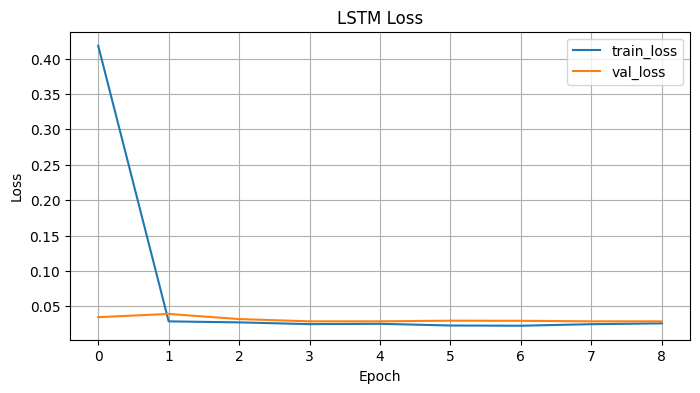

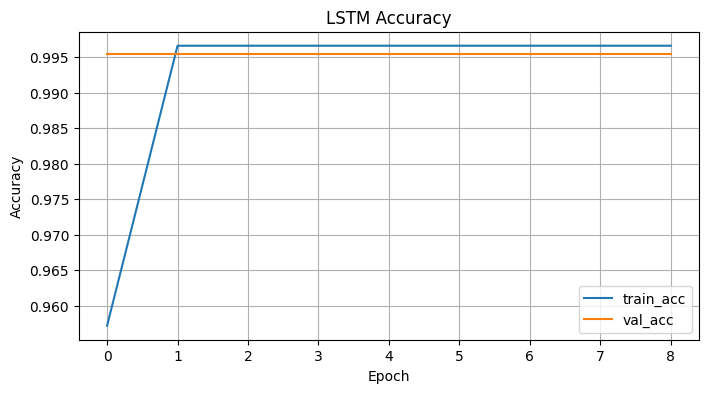

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
                          model  accuracy  precision    recall        f1  \
0                  RandomForest  1.000000   1.000000  1.000000  1.000000   
1                          LSTM  0.995516   0.991051  0.995516  0.993279   
2  Ensemble (0.6 LSTM + 0.4 RF)  0.995516   0.991051  0.995516  0.993279   

    roc_auc  
0  1.000000  
1  0.533784  
2  1.000000  


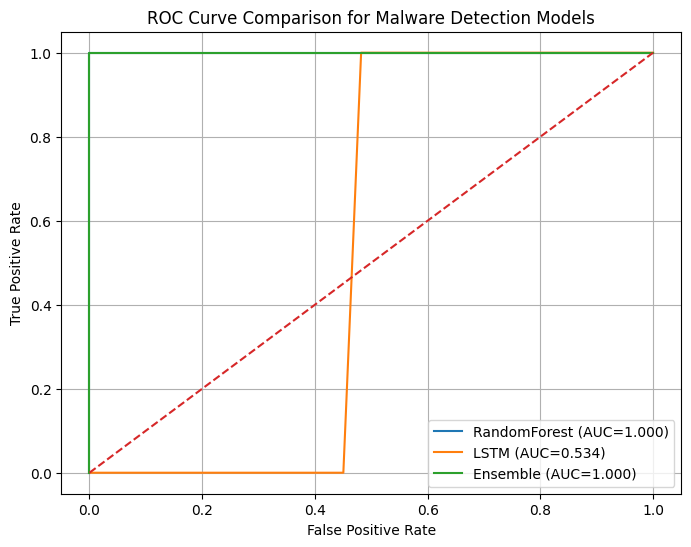

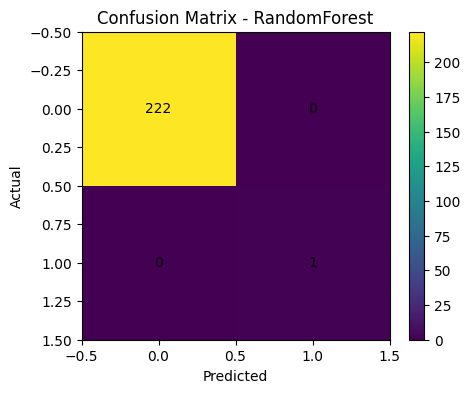

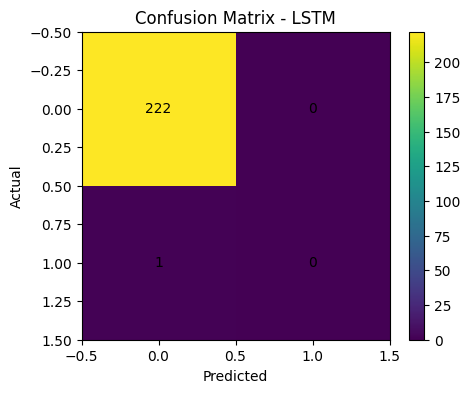

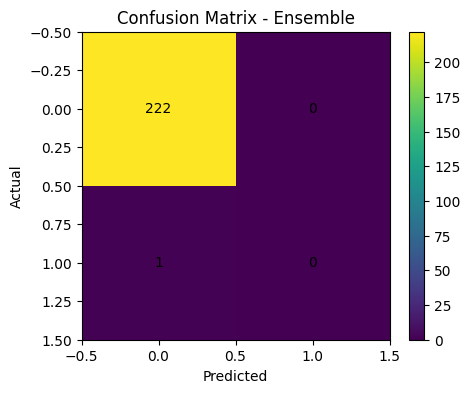

Training XGBoost for comparison...
Updated results:
                           model  accuracy  precision    recall        f1  \
0                  RandomForest  1.000000   1.000000  1.000000  1.000000   
1                          LSTM  0.995516   0.991051  0.995516  0.993279   
2  Ensemble (0.6 LSTM + 0.4 RF)  0.995516   0.991051  0.995516  0.993279   
3                       XGBoost  0.995516   0.991051  0.995516  0.993279   

    roc_auc  
0  1.000000  
1  0.533784  
2  1.000000  
3  0.993243  
Saved ensemble predictions to: C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\predictions_ensemble.csv
Finished. Saved RF -> C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\rf_model.joblib LSTM -> C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\lstm_model.keras


In [28]:
# ---------------- LSTM on dynamic features ----------------
tf.keras.backend.clear_session()
if use_text_sequence_for_lstm:
    vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index)+1)
    embedding_dim = 128
    lstm_units = 128
    if n_classes == 2:
        model = Sequential([
            InputLayer(input_shape=(Xd_train.shape[1],)),
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
            LSTM(lstm_units),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        loss = "binary_crossentropy"
    else:
        model = Sequential([
            InputLayer(input_shape=(Xd_train.shape[1],)),
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
            LSTM(lstm_units),
            Dropout(0.3),
            Dense(64, activation="relu"),
            Dense(n_classes, activation="softmax")
        ])
        loss = "sparse_categorical_crossentropy"
else:
    timesteps = Xd_train.shape[1]
    features_per_timestep = Xd_train.shape[2]
    lstm_units = 128
    if n_classes == 2:
        model = Sequential([
            InputLayer(input_shape=(timesteps, features_per_timestep)),
            LSTM(lstm_units),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        loss = "binary_crossentropy"
    else:
        model = Sequential([
            InputLayer(input_shape=(timesteps, features_per_timestep)),
            LSTM(lstm_units),
            Dropout(0.3),
            Dense(64, activation="relu"),
            Dense(n_classes, activation="softmax")
        ])
        loss = "sparse_categorical_crossentropy"

model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

# LSTM labels
y_train_lstm = y_train
y_test_lstm = y_test

epochs = 25
batch_size = 64 if Xd_train.shape[0] >= 64 else 16
es = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
lstm_checkpoint = r"C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\lstm_model_best.h5"
mc = ModelCheckpoint(lstm_checkpoint, monitor="val_loss", save_best_only=True, save_weights_only=False)

print("Training LSTM...")
history = model.fit(Xd_train, y_train_lstm, validation_data=(Xd_test, y_test_lstm), epochs=epochs, batch_size=batch_size, callbacks=[es, mc], verbose=2)
print("LSTM training done. Best checkpoint:", lstm_checkpoint)

# Save the full model (SavedModel)
saved_lstm_dir = r"C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\lstm_model.keras"
model.save(saved_lstm_dir)
print("Saved LSTM model to:", saved_lstm_dir)

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []))
plt.plot(history.history.get("val_loss", []))
plt.title("LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.grid(True)
plt.show()

if "accuracy" in history.history:
    plt.figure(figsize=(8,4))
    plt.plot(history.history.get("accuracy", []))
    plt.plot(history.history.get("val_accuracy", []))
    plt.title("LSTM Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train_acc", "val_acc"])
    plt.grid(True)
    plt.show()

# LSTM predictions
if n_classes == 2:
    lstm_proba_test = model.predict(Xd_test).ravel()
    lstm_pred = (lstm_proba_test >= 0.5).astype(int)
else:
    lstm_proba_test = model.predict(Xd_test)
    lstm_pred = np.argmax(lstm_proba_test, axis=1)

# Ensemble
weight_lstm = 0.6
weight_rf = 0.4
if n_classes == 2:
    ensemble_proba = weight_lstm * lstm_proba_test + weight_rf * rf_proba_test
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)
else:
    ensemble_proba = weight_lstm * lstm_proba_test + weight_rf * rf_proba_test
    ensemble_pred = np.argmax(ensemble_proba, axis=1)

# Metrics helper
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    roc = np.nan
    if y_proba is not None:
        try:
            if n_classes == 2:
                roc = roc_auc_score(y_true, y_proba)
            else:
                roc = roc_auc_score(y_true, y_proba, multi_class="ovr")
        except Exception:
            roc = np.nan
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc}

rf_pred = rf.predict(Xs_test)
rf_metrics = compute_metrics(y_test, rf_pred, rf_proba_test if n_classes==2 else rf_proba_test)
lstm_metrics = compute_metrics(y_test, lstm_pred, lstm_proba_test)
ensemble_metrics = compute_metrics(y_test, ensemble_pred, ensemble_proba)

results_df = pd.DataFrame([
    {"model":"RandomForest", **rf_metrics},
    {"model":"LSTM", **lstm_metrics},
    {"model":"Ensemble (0.6 LSTM + 0.4 RF)", **ensemble_metrics},
])
print(results_df)

# ROC plot (binary)
if n_classes == 2:
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba_test)
    fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_proba_test)
    fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={rf_metrics['roc_auc']:.3f})")
    plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC={lstm_metrics['roc_auc']:.3f})")
    plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC={ensemble_metrics['roc_auc']:.3f})")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison for Malware Detection Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# Confusion matrices plotted individually
cm_rf = confusion_matrix(y_test, rf_pred)
cm_lstm = confusion_matrix(y_test, lstm_pred)
cm_ens = confusion_matrix(y_test, ensemble_pred)

def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i,j]), ha="center", va="center")
    plt.colorbar()
    plt.show()

plot_confusion(cm_rf, "Confusion Matrix - RandomForest")
plot_confusion(cm_lstm, "Confusion Matrix - LSTM")
plot_confusion(cm_ens, "Confusion Matrix - Ensemble")

# Optional XGBoost
if XGBOOST_AVAILABLE:
    print("Training XGBoost for comparison...")
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=200, random_state=RANDOM_STATE)
    xgb_model.fit(Xs_train, y_train)
    xgb_proba_test = xgb_model.predict_proba(Xs_test)[:,1] if n_classes==2 else xgb_model.predict_proba(Xs_test)
    xgb_pred = xgb_model.predict(Xs_test)
    xgb_metrics = compute_metrics(y_test, xgb_pred, xgb_proba_test)
    results_df = pd.concat(
    [results_df, pd.DataFrame([{"model": "XGBoost", **xgb_metrics}])],
    ignore_index=True
)
    print("Updated results:\n", results_df)

# Save predictions CSV for review
out_df = pd.DataFrame({"y_true": y_test, "rf_pred": rf_pred, "lstm_pred": lstm_pred, "ensemble_pred": ensemble_pred})
out_csv = out_csv = r"C:\Users\Admin\github-classroom\Caty175\Caty-PolyWatch\ML model\predictions_ensemble.csv"
out_df.to_csv(out_csv, index=False)
print("Saved ensemble predictions to:", out_csv)
print("Finished. Saved RF ->", rf_path, "LSTM ->", saved_lstm_dir)
